# AB testing
#### Initially, the excel page of AB testing data is stored as csv file of ABtest.csv. Then, the dataset is aggregated for Control and Test groups. The Daily Visitors and Total Enquiries are selected as visit and converted respectively. So, the conversion is enquiry/visit.

#### My approach for AB testing is using stochastic modelling and particularly, using Markov chain Monte Carlo (MCMC) simulation to calculate the posterior probability of A and B conversion.

In [24]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
from scipy.stats import beta
import math

In [25]:
AB = pd.read_csv("ABtest.csv")

In [26]:
AB.head()

,Time Period,Segment,Total Enquiries,Private Enquiries,Used Enquiries,BNCIS Enquiries,New Enquiries,Demo Enquiries,Dealer Enquiries,Visits,Daily Visitors
0,8/18/2016,Control,2545.0,1202.0,1134.0,62.0,9.0,107.0,1343.0,84827.0,57648
1,8/18/2016,Test,143.0,73.0,55.0,4.0,0.0,11.0,70.0,5088.0,3375
2,8/19/2016,Control,4228.0,1966.0,1907.0,98.0,1.0,220.0,2261.0,133868.0,94289
3,8/19/2016,Test,252.0,129.0,111.0,1.0,0.0,8.0,123.0,7965.0,5511
4,8/20/2016,Control,3940.0,1805.0,1839.0,95.0,16.0,154.0,2133.0,121742.0,84459


In [27]:
AB2 =AB.groupby(AB['Segment']).sum()
AB2.head()

,Total Enquiries,Private Enquiries,Used Enquiries,BNCIS Enquiries,New Enquiries,Demo Enquiries,Dealer Enquiries,Visits,Daily Visitors
Segment,,,,,,,,,
Control,192125.0,91641.0,85592.0,3859.0,420.0,8920.0,100434.0,6182861.0,4421346
Test,11308.0,5705.0,4809.0,192.0,27.0,473.0,5601.0,353830.0,250864


Allocating the visit and success (enquiry)for both control(T0) and test (T1)

In [28]:
T0_visit=AB2.loc["Control ", 'Daily Visitors']
T0_succ=AB2.loc["Control ", 'Total Enquiries'] 
T1_visit=AB2.loc["Test", 'Daily Visitors']
T1_succ=AB2.loc["Test", 'Total Enquiries']

##### function to calculate the posterior probability of Bayesian statistics. 

In [29]:
# function to calculate the posterior probability of Bayesian statistics
def generate_beta_posteriors(conversions,
                             visits,
                             alpha_prior=1,
                             beta_prior=1,
                             n_samples=10000):
    observations = beta(alpha_prior + conversions,beta_prior + visits - conversions)
    posterior_samples = observations.rvs(n_samples)
    return posterior_samples

## The prior of alpha and beta is assumed 1. It means there is no data before this analysis. However, for the next AB testing, the priors of the alpha and beta for control segment could be previous Visit and Enquiry of Control segment.


 Below function Computes highest density interval from a sample of representative values,
    estimated as the shortest credible interval
    Takes Arguments posterior_samples (samples from posterior) and credible
    mass (normally .95)

In [30]:
def HDI_from_MCMC(posterior_samples, credible_mass=0.95):
    # Computes highest density interval from a sample of representative values,
    # estimated as the shortest credible interval
    # Takes Arguments posterior_samples (samples from posterior) and credible
    # mass (normally .95)
    sorted_points = np.sort(posterior_samples)
    ciIdxInc = np.ceil(credible_mass * len(sorted_points)).astype('int')
    nCIs = len(sorted_points) - ciIdxInc
    ciWidth = [0] * nCIs
    for i in range(0, nCIs):
        ciWidth[i] = sorted_points[i + ciIdxInc] - sorted_points[i]
    HDImin = sorted_points[ciWidth.index(min(ciWidth))]
    HDImax = sorted_points[ciWidth.index(min(ciWidth)) + ciIdxInc]
    return(HDImin, HDImax)


Calculating contingency table

In [31]:
table = [[T0_succ,T1_succ],[(T0_visit-T0_succ), (T1_visit-T1_succ)]]
stat, p, dof, expected = chi2_contingency(table, correction=True)
print(stat, p, dof, expected )

14.962867621478273 0.00010964774257198448 1 [[ 192510.11423245   10922.88576755]
 [4228835.88576755  239941.11423245]]


#### calculate the probability that conversion rate of Test group is better than that of Control group.

In [32]:
Bayespost_T0=generate_beta_posteriors(T0_succ,T0_visit,alpha_prior=1,beta_prior=1,n_samples=10000)
Bayespost_T1=generate_beta_posteriors(T1_succ,T1_visit ,alpha_prior=1,beta_prior=1,n_samples=10000)
pd = '{0:3.1f}'.format(100 * (Bayespost_T1> Bayespost_T0).mean())
print(pd)

100.0


#### calculate the range of conversion difference between Test and Control group.

In [33]:
difference=Bayespost_T1-Bayespost_T0
#get the mean of the difference
average=np.mean(difference)
#now get thelower and upper bounds of the 95% HDP
a=HDI_from_MCMC(difference)
lower=a[0]
upper=a[1]
print('Mean, upper and lower difference between test and control is: ', average,lower,upper)

Mean, upper and lower difference between test and control is:  0.0016217581672343833 0.0008120825099147203 0.0024793442312759442


In [34]:
a=100*(Bayespost_T1.mean()-Bayespost_T0.mean())/Bayespost_T0.mean()
b="%.2f" % a
print (f"There is a probablity of {pd}% that Test option lift Conversion Rate by {b}% .")

There is a probablity of 100.0% that Test option lift Conversion Rate by 3.73% .


#### Drawing the posterior distribution of Control and Test conversions.

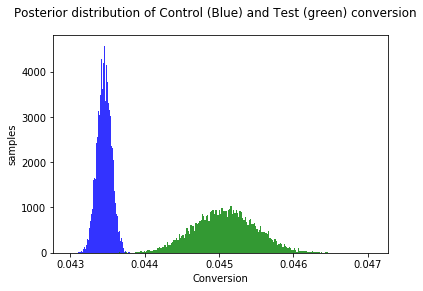

In [35]:
fig = plt.figure()
x,bins,p=plt.hist(Bayespost_T0,bins=200, alpha=0.8, color='B',density=1);
y,ybin,py=plt.hist(Bayespost_T1,bins=200, alpha=0.8, color='G',density=1);
fig.suptitle('Posterior distribution of Control (Blue) and Test (green) conversion')
plt.xlabel('Conversion')
plt.ylabel('samples')
plt.savefig('Posterior distributions.png',bbox_inches='tight')

As you can see, there is almost no overlap between cntrol (blue left hand) and test (green right hand).In case of overlap, the Analyst, according to the probability, can decide whether the test conversion is still better than the control conversion. Here, the above probability is 100%. 